In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import altair as alt
from vega_datasets import data
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
alt.renderers.enable('notebook') # embed_options={'actions': False})

RendererRegistry.enable('notebook')

In [3]:
import pymc3 as pm

# Gun suicides descriptives

In [5]:
suicides = pd.read_csv("./inputs/all_suicides2007_2016.txt", sep="\t")
pop_df = pd.read_csv("./inputs/census_pop2016_m.csv", quoting=1, encoding='latin-1')

suicides['State'] = suicides['County'].apply(lambda x: x.split(', ')[1])
suicides = suicides.drop(['County','Population'], axis=1)

gun_suicide = ['X72', 'X73', 'X74']
nyears = 10

In [6]:
pop_df.head()

,id2,County,Population,log_pop
0,1001,"Autauga County, Alabama",55416,10.922624
1,1003,"Baldwin County, Alabama",208563,12.247996
2,1005,"Barbour County, Alabama",25965,10.164505
3,1007,"Bibb County, Alabama",22643,10.027606
4,1009,"Blount County, Alabama",57704,10.963082


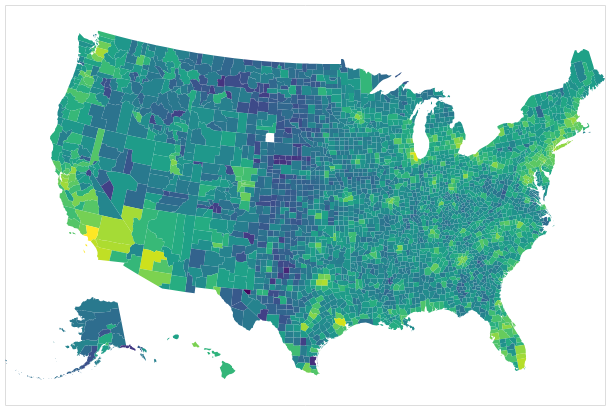

In [8]:
counties = alt.topo_feature(data.us_10m.url, 'counties')
source = "./census_pop2016_m.csv"

alt.Chart(counties).mark_geoshape().encode(
    color=alt.Color('log_pop:Q', legend=None),
    tooltip=['County:N','Population:Q']
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(source, 'id2', ['log_pop','County','Population'])
).project(
    type='albersUsa'
).properties(
    width=600,
    height=400
)

Text(0.5,0,'Population')

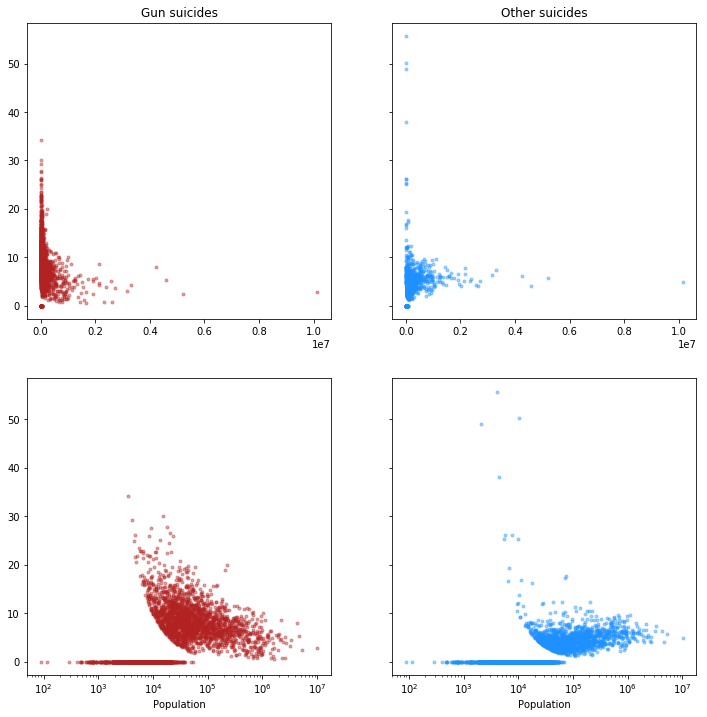

In [12]:
state_filter = suicides.State.unique() #['MA', 'TX'] #, 'TX', 'NY', 'FL'] #suicides.State.unique() #['PA'] #, 'MA', 'AL', 'TX', 'NY', 'FL'] #suicides.State.unique()

suicides_gun = suicides[(suicides['Cause of death Code'].isin(gun_suicide)) & suicides.State.isin(state_filter)]
suicides_gun = suicides_gun.merge(pop_df[['id2','County', 'Population']], left_on='County Code', 
                   right_on='id2', how='right').fillna(0.0)
suicides_gun = suicides_gun.groupby(['County','id2']).agg({'Population':np.nanmean, 'Deaths':np.sum}).reset_index()
suicides_gun['rate'] = suicides_gun['Deaths'] / (suicides_gun['Population'] * 10)


suicides_other = suicides[(~suicides['Cause of death Code'].isin(gun_suicide)) & suicides.State.isin(state_filter)]
suicides_other = suicides_other.merge(pop_df[['id2','County', 'Population']], left_on='County Code', 
                   right_on='id2', how='right').fillna(0.0)
suicides_other = suicides_other.groupby(['County','id2']).agg({'Population':np.nanmean, 'Deaths':np.sum}).reset_index()
suicides_other['rate'] = suicides_other['Deaths'] / (suicides_other['Population'] * 10)


f, axes = plt.subplots(2,2, figsize=(12,12), sharey=True)
p1 = axes[0,0].plot(suicides_gun['Population'], suicides_gun['rate'] * 100000, '.', color='firebrick', alpha=0.4, label='suicides - gun')
p2 = axes[0,1].plot(suicides_other['Population'], suicides_other['rate'] * 100000, '.', color='dodgerblue', alpha=0.4, label='suicides - other')
axes[0,0].set_title("Gun suicides")
axes[0,1].set_title("Other suicides")

p1 = axes[1,0].plot(suicides_gun['Population'], suicides_gun['rate'] * 100000, '.', color='firebrick', alpha=0.4, label='suicides - gun')
p2 = axes[1,1].plot(suicides_other['Population'], suicides_other['rate'] * 100000, '.b', color='dodgerblue', alpha=0.4, label='suicides - other')
axes[1,0].semilogx()
axes[1,1].semilogx()

axes[1,0].set_xlabel("Population")
axes[1,1].set_xlabel("Population")


#_ = ax2.loglog()


In [13]:
low_g, high_g = suicides_gun.rate.quantile([0.05, 0.95])
low_o, high_o = suicides_other.rate.quantile([0.05, 0.95])

In [91]:
suicides_other['log_rate'].sort_values().unique()[-1]

-5.0848852056628768

In [93]:
suicides_gun['high_rate'] = suicides_gun.rate.apply(lambda x: int(x >= high_g))
suicides_gun['low_rate'] = suicides_gun.rate.apply(lambda x: int(x <= low_g))
suicides_gun['id2'] = suicides_gun['id2'].astype(int) 
suicides_gun['log_rate'] = suicides_gun['rate'].apply(np.log)
min_val = suicides_gun['log_rate'].sort_values().unique()[1]
suicides_gun.loc[np.isinf(suicides_gun['log_rate']),'log_rate']  = (min_val + min_val/2)
suicides_gun.to_csv("./outputs/suicides_gun_raw.csv", index=False)
suicides_gun.head()

suicides_other['high_rate'] = suicides_other.rate.apply(lambda x: int(x >= high_o))
suicides_other['low_rate'] = suicides_other.rate.apply(lambda x: int(x <= low_o))
suicides_other['id2'] = suicides_other['id2'].astype(int) 
suicides_other['log_rate'] = suicides_other['rate'].apply(np.log)
min_val = suicides_other['log_rate'].sort_values().unique()[1]
suicides_other.loc[np.isinf(suicides_other['log_rate']),'log_rate']  = (min_val +  min_val/2)
suicides_other.to_csv("./outputs/suicides_other_raw.csv", index=False)
suicides_other.head()


,County,id2,Population,Deaths,rate,high_rate,low_rate,post_rate_mm,post_low,post_high,post_rate_hyp,post_low_hyp,post_high_hyp,post_rate_hypypst,post_low_hypst,post_high_hypst,post_rate_hyp_pty,post_low_hyp_pty,post_high_hyp_pty,log_rate
0,"Abbeville County, South Carolina",45001,24872,0.0,0.000000,0,1,0.000002,6.565675e-14,0.000007,0.000001,4.702014e-19,0.000006,1.148541e-06,1.136428e-18,0.000005,1.148541e-06,1.136428e-18,0.000005,-16.977316
1,"Acadia Parish, Louisiana",22001,62645,24.0,0.000038,0,0,0.000038,2.306759e-05,0.000053,0.000038,2.319869e-05,0.000053,3.786344e-05,2.333698e-05,0.000053,3.786344e-05,2.333698e-05,0.000053,-10.169770
2,"Accomack County, Virginia",51001,32947,0.0,0.000000,0,1,0.000001,4.948312e-16,0.000005,0.000001,9.867871e-16,0.000004,8.902447e-07,2.783369e-22,0.000004,8.902447e-07,2.783369e-22,0.000004,-16.977316
3,"Ada County, Idaho",16001,444028,287.0,0.000065,0,0,0.000064,5.669233e-05,0.000072,0.000064,5.707691e-05,0.000072,6.447728e-05,5.731078e-05,0.000072,6.447728e-05,5.731078e-05,0.000072,-9.646746
4,"Adair County, Iowa",19001,7092,0.0,0.000000,0,1,0.000005,2.165775e-16,0.000020,0.000004,4.965169e-16,0.000018,3.452896e-06,2.835976e-17,0.000016,3.452896e-06,2.835976e-17,0.000016,-16.977316


In [87]:
list(reversed(["#c30d24", "#f3a583", "#cccccc", "#94c6da", "#1770ab"]))

['#1770ab', '#94c6da', '#cccccc', '#f3a583', '#c30d24']

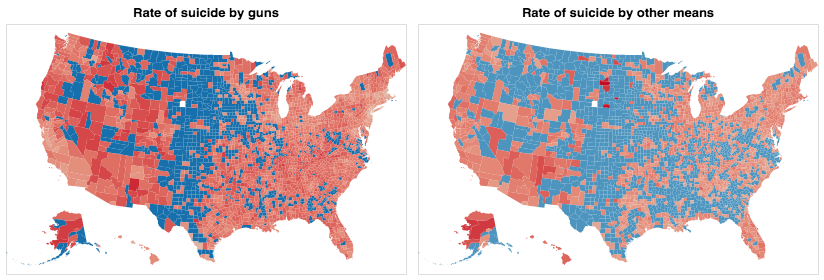

In [110]:
counties = alt.topo_feature(data.us_10m.url, 'counties')
source_gun = "https://raw.githubusercontent.com/sidravi1/sidravi1.github.io/master/assets/suicides_gun_raw.csv"

left = alt.Chart(counties).mark_geoshape().encode(
    tooltip=['County:N','Population:Q', 'Deaths:Q'],
    color=alt.Color('log_rate:Q', legend=None, scale=alt.Scale(
                      range=['#1770ab', '#94c6da', '#cccccc', '#f3a583', '#c30d24']))
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(source_gun, 'id2', ['County','log_rate','Deaths','rate','Population'])
).project(
    type='albersUsa'
).properties(
    width=400,
    height=250,
    title ='Rate of suicide by guns'
)

source_other = "https://raw.githubusercontent.com/sidravi1/sidravi1.github.io/master/assets/suicides_other_raw.csv"
right = alt.Chart(counties).mark_geoshape().encode(
    tooltip=['County:N','Population:Q', 'Deaths:Q'],
    color=alt.Color('log_rate:Q', legend=None)
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(source_other, 'id2', ['County','log_rate','rate','Deaths','Population'])
).project(
    type='albersUsa'
).properties(
    width=400,
    height=250,
    title ='Rate of suicide by other means'
)

alt.hconcat(left, right)

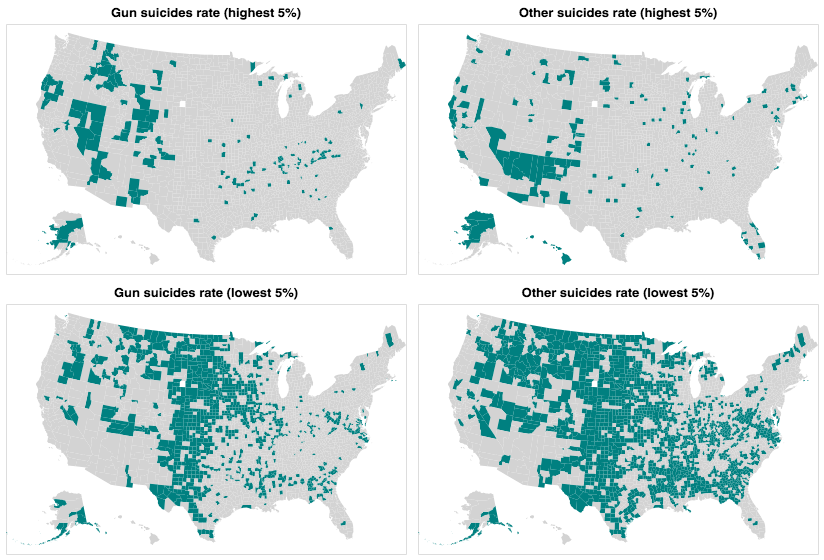

In [16]:
counties = alt.topo_feature(data.us_10m.url, 'counties')
source_gun = "./suicides_gun_raw.csv"

left_base = alt.Chart(counties).mark_geoshape().encode(
    tooltip=['County:N','Population:Q']
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(source_gun, 'id2', ['County','high_rate','low_rate','Population'])
).project(
    type='albersUsa'
).properties(
    width=400,
    height=250,
    
)

source_other = "./suicides_other_raw.csv"
right_base = alt.Chart(counties).mark_geoshape().encode(
    tooltip=['County:N','Population:Q']
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(source_other, 'id2', ['County','high_rate','low_rate','Population'])
).project(
    type='albersUsa'
).properties(
    width=400,
    height=250
)

left_top = left_base.encode(color=alt.Color('high_rate:Q', legend=None, 
                                            scale=alt.Scale(domain=[0,1],
                                                            range=['lightgray','teal']))
                               ).properties(title="Gun suicides rate (highest 5%)")
left_bot = left_base.encode(color=alt.Color('low_rate:Q', legend=None, 
                                            scale=alt.Scale(domain=[0,1],
                                                            range=['lightgray','teal']))
                           ).properties(title="Gun suicides rate (lowest 5%)")


right_top = right_base.encode(color=alt.Color('high_rate:Q', legend=None, 
                                            scale=alt.Scale(domain=[0,1],
                                                            range=['lightgray','teal']))
                             ).properties(title="Other suicides rate (highest 5%)")
right_bot = right_base.encode(color=alt.Color('low_rate:Q', legend=None, 
                                            scale=alt.Scale(domain=[0,1],
                                                            range=['lightgray','teal']))
                             ).properties(title="Other suicides rate (lowest 5%)")

left = alt.vconcat(left_top, left_bot)
right = alt.vconcat(right_top, right_bot)

alt.hconcat(left, right)

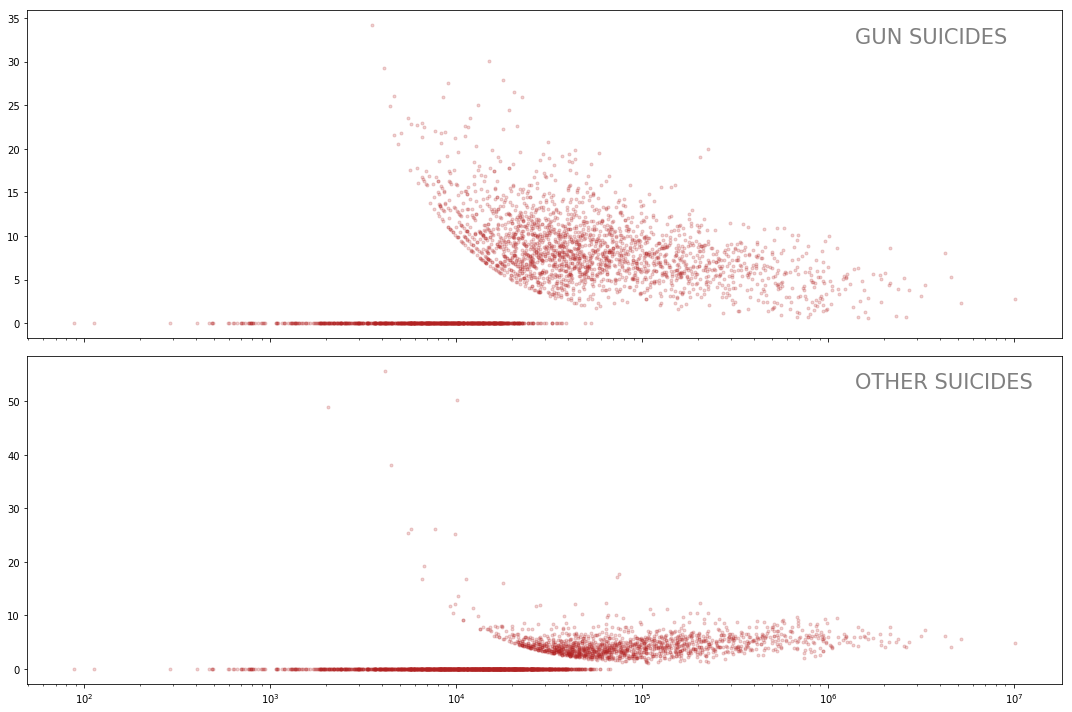

In [17]:
f, axes = plt.subplots(2, 1, figsize=(15,10), sharex=True)

for df, ax in zip([suicides_gun, suicides_other], axes):
    p1 = ax.plot(df['Population'], df['rate'] * 100000, '.', color='firebrick', alpha=0.2, label='suicides - gun')
    
axes[0].annotate("GUN SUICIDES", xy=(0.8, 0.9), xycoords='axes fraction', fontsize=21, color='gray', ha='left' )
axes[1].annotate("OTHER SUICIDES", xy=(0.8, 0.9), xycoords='axes fraction', fontsize=21, color='gray', ha='left' )

plt.semilogx()
plt.tight_layout()


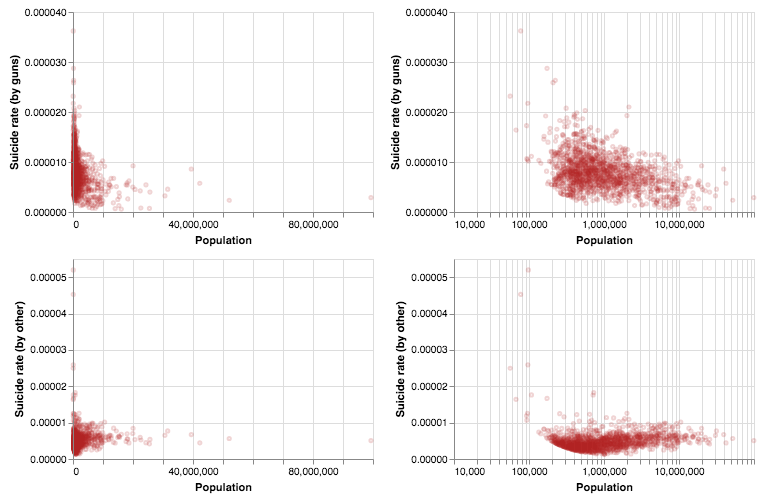

In [18]:
source = "./suicides_posterior.csv"

brush = alt.selection(type='interval', resolve='global', )

base = alt.Chart(source).mark_point(size=10, opacity=0.2).encode(
    x=alt.X('Population:Q',scale=alt.Scale(type='log')),
    color=alt.condition(brush, alt.ColorValue('firebrick'), alt.ColorValue('gray')),
    #color=alt.condition(brush, alt.Color('dem_or_gop:N',scale=alt.Scale(domain=['GOP','DEM'], range=['firebrick','dodgerblue']), title="Party"), alt.ColorValue('gray')),
    tooltip=['Deaths_gun:Q', 'Deaths_other:Q', 'County:N'] #alt.Tooltip(field='Deaths_gun', type='quantitative')
).properties(
    width=300,
    height=200
).add_selection(
    brush
)

top_left = base.encode(y=alt.Y('rate_gun:Q', title='Suicide rate (by guns)'), 
                       x=alt.X('Population:Q',scale=alt.Scale(type='linear')))
bottom_left = base.encode(y=alt.Y('rate_other:Q', title='Suicide rate (by other)'),
                       x=alt.X('Population:Q',scale=alt.Scale(type='linear')))

left = alt.vconcat(top_left, bottom_left).resolve_scale(x='shared')

top_right = base.encode(y=alt.Y('rate_gun:Q', title='Suicide rate (by guns)'))
bottom_right = base.encode(y=alt.Y('rate_other:Q', title='Suicide rate (by other)'))

right = alt.vconcat(top_right, bottom_right).resolve_scale(x='shared')

alt.hconcat(left, right).resolve_scale(y='shared')


## Moment matching

For gun suicides data

In [19]:
pop = suicides_gun['Population'].mean() 
y = suicides_gun['Deaths']/suicides_gun['Population']

E = y.mean()
V = y.var(ddof=1)

b_gun = 10 / (V/E - 1/pop)
b_gun

a_gun = E * b_gun / 10
a_gun, b_gun

(1.32395573801243, 22400.559894441012)

In [20]:
suicides_other.head()

,County,id2,Population,Deaths,rate,high_rate,low_rate
0,"Abbeville County, South Carolina",45001,24872,0.0,0.000000,0,1
1,"Acadia Parish, Louisiana",22001,62645,24.0,0.000038,0,0
2,"Accomack County, Virginia",51001,32947,0.0,0.000000,0,1
3,"Ada County, Idaho",16001,444028,287.0,0.000065,0,0
4,"Adair County, Iowa",19001,7092,0.0,0.000000,0,1


For other suicides data

In [21]:
pop = suicides_other['Population'].mean() 
y = suicides_other['Deaths']/suicides_other['Population']

E = y.mean()
V = y.var(ddof=1)

b_other = 10 / (np.exp(np.log(V) - np.log(E)) - 1/pop) # In logs terms to avoid overflows
b_other

a_other = E * b_other / 10
a_other, b_other

(0.47909134107722096, 21515.476063429942)

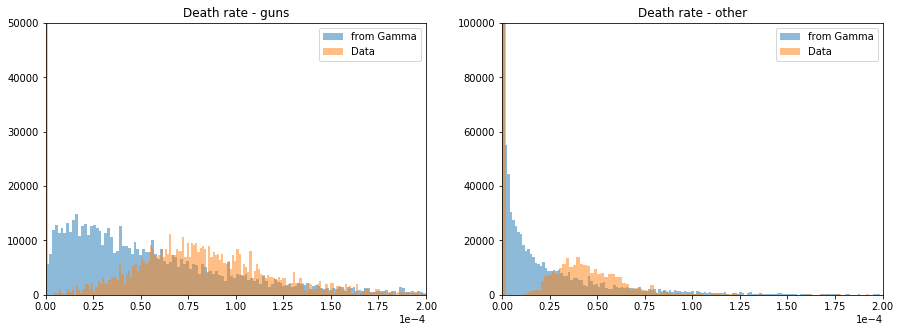

In [27]:
samples_gun = np.random.gamma(a_gun, 1/b_gun, 5000)
samples_other = np.random.gamma(a_other, 1/b_other, 5000)

f, axes = plt.subplots(1,2,figsize=(15,5))
_ = axes[0].hist(samples_gun, bins=300, normed=True, alpha = 0.5, label='from Gamma')
_ = axes[0].hist(suicides_gun.rate, bins=300, normed=True, alpha = 0.5, label='Data')

_ = axes[1].hist(samples_other, bins=300, normed=True, alpha = 0.5, label='from Gamma')
_ = axes[1].hist(suicides_other.rate, bins=300, normed=True, alpha = 0.5, label='Data')

axes[0].set_title("Death rate - guns")
axes[1].set_title("Death rate - other")
axes[0].legend()
axes[1].legend()
axes[0].set_xlim([0,0.0002])
axes[1].set_xlim([0,0.0002])
axes[0].set_ylim([0,50000])
axes[1].set_ylim([0,100000])

axes[0].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
axes[1].ticklabel_format(style='sci', axis='x', scilimits=(0,0))

plt.savefig("./outputs/2018-06-15-moment_matching.png")


In [23]:
pop_gun = suicides_gun['Population'].values
deaths_gun = suicides_gun['Deaths'].values

pop_other = suicides_other['Population'].values
deaths_other = suicides_other['Deaths'].values

In [24]:
samples_other.std(), suicides_other.rate.std()

(3.1467572794571962e-05, 3.250530738459604e-05)

In [25]:
with pm.Model() as mmatching:
    rate_gun = pm.Gamma('rate_gun', a_gun, b_gun, shape=len(suicides_gun))
    likelihood_gun = pm.Poisson('likelihood_gun', mu = 10*pop_gun*rate_gun, 
                            observed = deaths_gun)
    
    rate_other = pm.Gamma('rate_other', a_other, b_other, shape=len(suicides_other))
    likelihood_deaths = pm.Poisson('likelihood_other', mu = 10*pop_other*rate_other, 
                            observed = deaths_other)

In [26]:
trace_mm = pm.sample(tune=1000, draws=5000, model=mmatching)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rate_other_log__, rate_gun_log__]
100%|██████████| 6000/6000 [04:12<00:00, 23.78it/s]


In [28]:
res = pm.summary(trace_mm).reset_index()
res_gun = res[res['index'].str.startswith('rate_gun')]
res_other = res[res['index'].str.startswith('rate_other')]

In [29]:
suicides_gun['post_rate_mm'] = res_gun['mean'].values
suicides_gun['post_low'] = res_gun['hpd_2.5'].values
suicides_gun['post_high'] = res_gun['hpd_97.5'].values

suicides_other['post_rate_mm'] = res_other['mean'].values
suicides_other['post_low'] = res_other['hpd_2.5'].values
suicides_other['post_high'] = res_other['hpd_97.5'].values

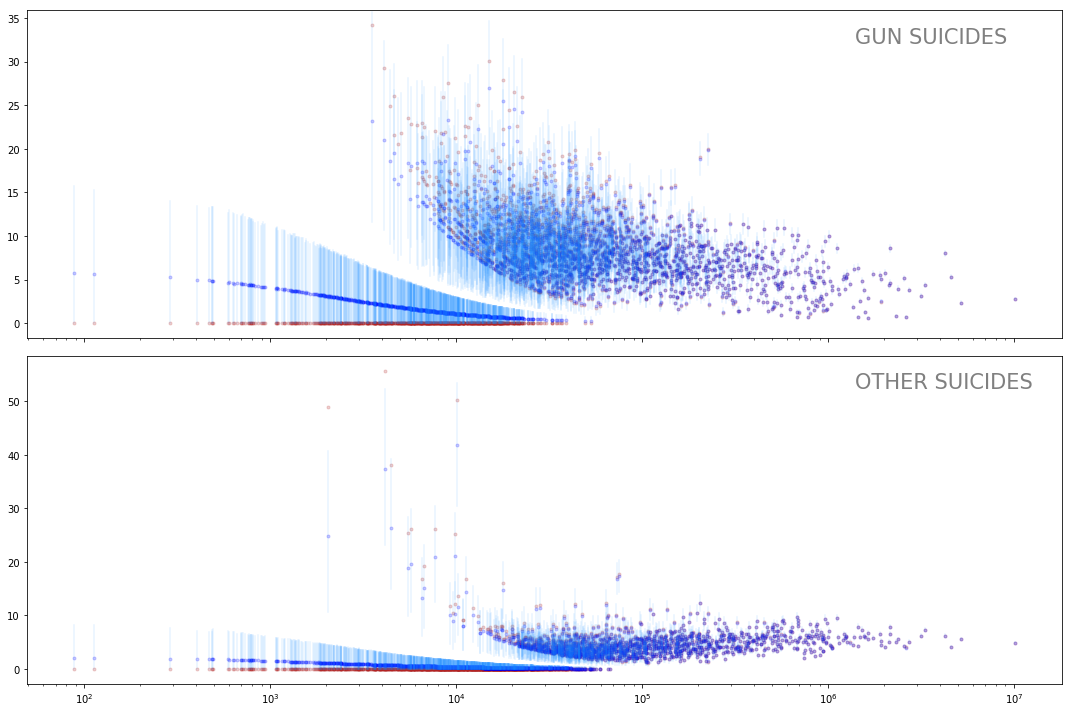

In [30]:
f, axes = plt.subplots(2, 1, figsize=(15,10), sharex=True)

for df, ax in zip([suicides_gun, suicides_other], axes):
    p1 = ax.plot(df['Population'], df['rate'] * 100000, '.', color='firebrick', alpha=0.2, label='suicides - gun')
    p2 = ax.plot(df['Population'], df['post_rate_mm'] * 100000, '.', color='blue', alpha=0.2, label='suicides - other') 
    ylow, yhigh = ax.get_ylim()
    for x,y1,y2 in df[['Population','post_low', 'post_high']].itertuples(index=False):
        p3 = ax.axvline(x, (y1 * 100000 - ylow) / (yhigh - ylow), (y2 * 100000 - ylow)/(yhigh - ylow) , color='dodgerblue', alpha = 0.1)

axes[0].annotate("GUN SUICIDES", xy=(0.8, 0.9), xycoords='axes fraction', fontsize=21, color='gray', ha='left' )
axes[1].annotate("OTHER SUICIDES", xy=(0.8, 0.9), xycoords='axes fraction', fontsize=21, color='gray', ha='left' )

plt.semilogx()
plt.tight_layout()

plt.savefig("./outputs/2018-06-15-empirical-shrinkage.png")


## With hyper params

In [31]:
with pm.Model() as mhyper:
    alpha_gun = pm.HalfCauchy('alpha_gun', 4)
    beta_gun = pm.HalfCauchy('beta_gun', 4)

    alpha_other = pm.HalfCauchy('alpha_other', 4)
    beta_other = pm.HalfCauchy('beta_other', 4)
    
    rate_gun = pm.Gamma('rate_gun', alpha_gun, beta_gun, shape=len(suicides_gun))
    rate_other = pm.Gamma('rate_other', alpha_other, beta_other, shape=len(suicides_other))
    
    likelihood_gun = pm.Poisson('likelihood_gun', mu = 10 * rate_gun * pop_gun, 
                            observed = deaths_gun)
    
    likelihood_other = pm.Poisson('likelihood_other', mu = 10 * rate_other * pop_other, 
                            observed = deaths_other)

In [34]:
trace_hyper = pm.sample(init='advi', tune =1000, draws=5000, model=mhyper)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 23,511: 100%|██████████| 200000/200000 [09:12<00:00, 362.16it/s]   
Finished [100%]: Average Loss = 23,512
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rate_other_log__, rate_gun_log__, beta_other_log__, alpha_other_log__, beta_gun_log__, alpha_gun_log__]
100%|██████████| 6000/6000 [04:24<00:00, 22.71it/s]
The number of effective samples is smaller than 10% for some parameters.


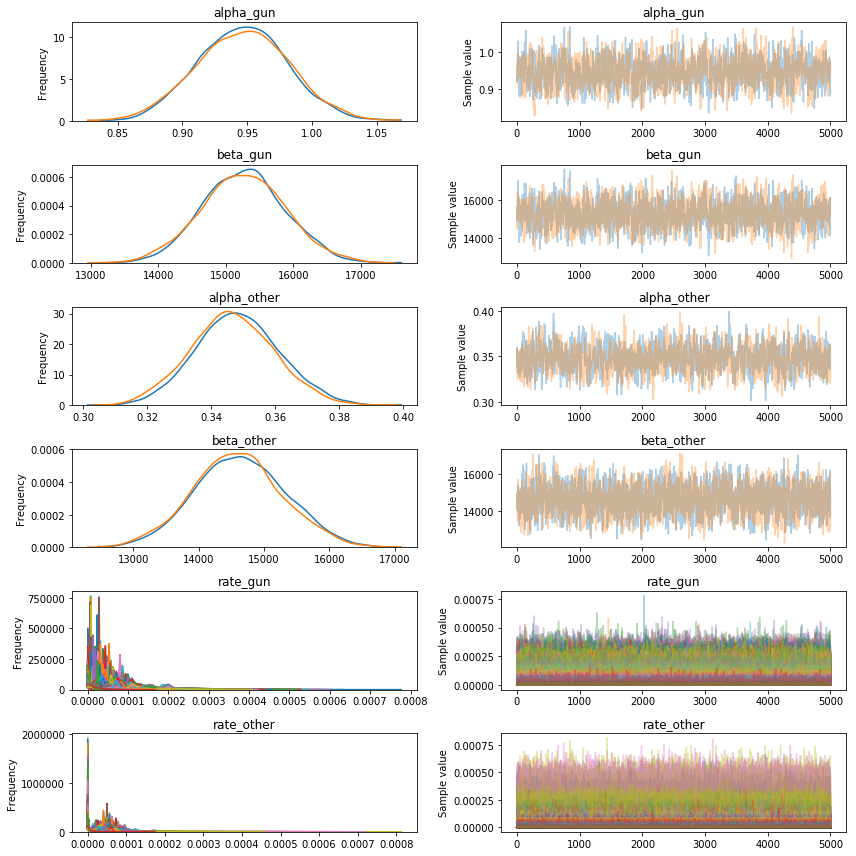

In [35]:
_ = pm.traceplot(trace_hyper)

In [36]:
res = pm.summary(trace_hyper).reset_index()
res_gun = res[res['index'].str.startswith('rate_gun')]
res_other = res[res['index'].str.startswith('rate_other')]

In [37]:
suicides_gun['post_rate_hyp'] = res_gun['mean'].values
suicides_gun['post_low_hyp'] = res_gun['hpd_2.5'].values
suicides_gun['post_high_hyp'] = res_gun['hpd_97.5'].values

suicides_other['post_rate_hyp'] = res_other['mean'].values
suicides_other['post_low_hyp'] = res_other['hpd_2.5'].values
suicides_other['post_high_hyp'] = res_other['hpd_97.5'].values

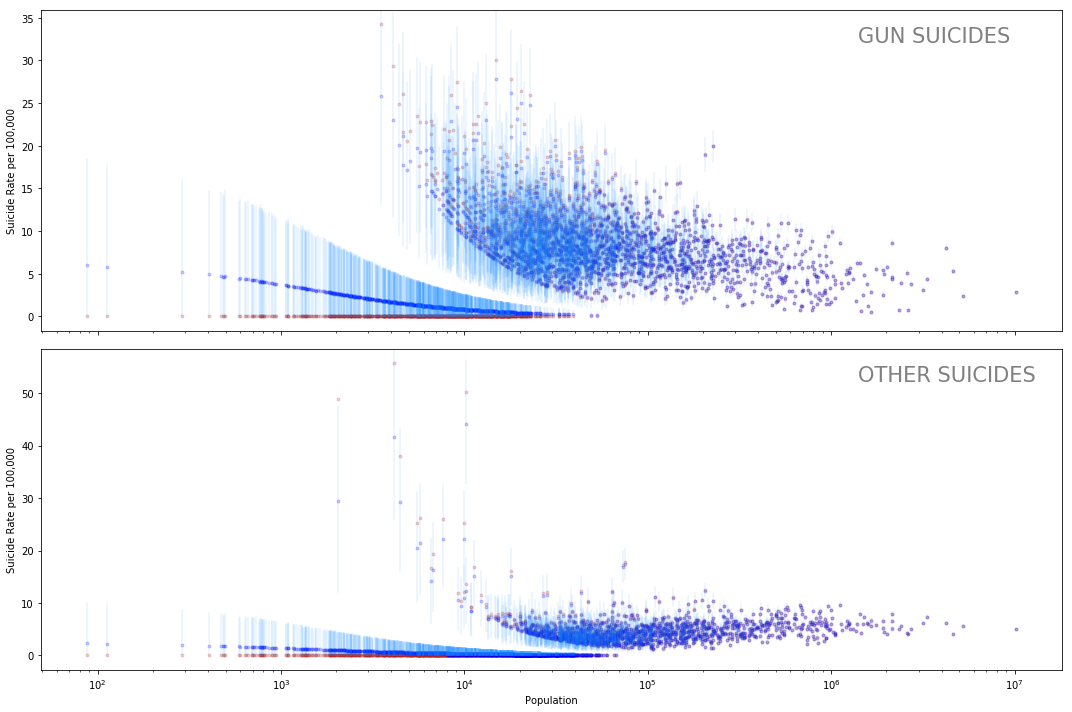

In [38]:
f, axes = plt.subplots(2, 1, figsize=(15,10), sharex=True)

for df, ax in zip([suicides_gun, suicides_other], axes):
    p1 = ax.plot(df['Population'], df['rate'] * 100000, '.', color='firebrick', alpha=0.2, label='suicides - gun')
    p2 = ax.plot(df['Population'], df['post_rate_hyp'] * 100000, '.', color='blue', alpha=0.2, label='suicides - other') 
    ylow, yhigh = ax.get_ylim()
    for x,y1,y2 in df[['Population','post_low_hyp', 'post_high_hyp']].itertuples(index=False):
        p3 = ax.axvline(x, (y1 * 100000 - ylow) / (yhigh - ylow), (y2 * 100000 - ylow)/(yhigh - ylow) , color='dodgerblue', alpha = 0.1)

axes[0].annotate("GUN SUICIDES", xy=(0.8, 0.9), xycoords='axes fraction', fontsize=21, color='gray', ha='left' )
axes[1].annotate("OTHER SUICIDES", xy=(0.8, 0.9), xycoords='axes fraction', fontsize=21, color='gray', ha='left' )

axes[1].set_xlabel("Population")
axes[1].set_ylabel("Suicide Rate per 100,000")
axes[0].set_ylabel("Suicide Rate per 100,000")

plt.semilogx()
plt.tight_layout()

plt.savefig("./outputs/2018-06-15-hierarchical-shrinkage.png")

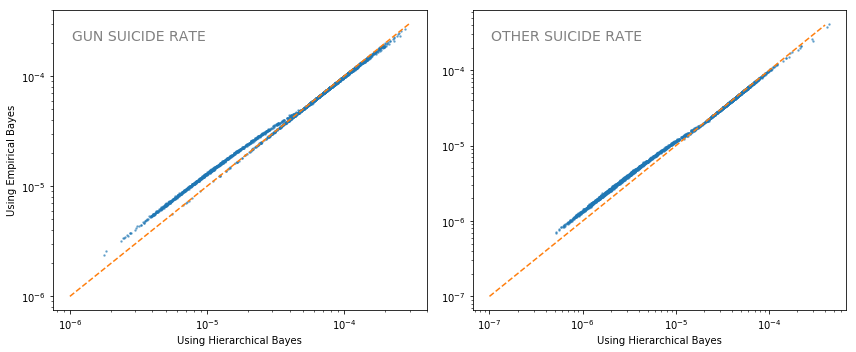

In [119]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.plot(suicides_gun['post_rate_hyp'], suicides_gun['post_rate_mm'], '.', ms=3, alpha=0.5)
ax1.plot([0.000001,0.0003], [0.000001, 0.0003], '--')

ax2.plot(suicides_other['post_rate_hyp'], suicides_other['post_rate_mm'], '.', ms=3, alpha=0.5)
ax2.plot([0.0000001,0.0004], [0.0000001, 0.0004], '--')
ax1.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
ax2.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
ax2.loglog()
ax1.loglog()

ax1.set_ylabel("Using Empirical Bayes")
ax1.set_xlabel("Using Hierarchical Bayes")
ax2.set_xlabel("Using Hierarchical Bayes")
ax1.annotate("GUN SUICIDE RATE", xy=(0.05, 0.9), xycoords='axes fraction', fontsize=14, color='gray', ha='left' )
ax2.annotate("OTHER SUICIDE RATE", xy=(0.05, 0.9), xycoords='axes fraction', fontsize=14, color='gray', ha='left' )

plt.tight_layout()

plt.savefig("./2018-06-15-hierarchical_vs_empirical.png")

## Party level hyper

In [41]:
election2016 = pd.read_csv("./inputs/2016USPresidentialElectionResultsbyCounty.csv", 
            dtype={'combined_fips_fill':str})

In [44]:
suicides_gun2 = suicides_gun.merge(election2016[['combined_fips','dem_or_gop']], left_on=['id2'], 
                   right_on='combined_fips', how='left')
party_gun = suicides_gun2.dem_or_gop.astype('category').cat.codes

In [45]:
suicides_other2 = suicides_other.merge(election2016[['combined_fips','dem_or_gop']], left_on=['id2'], 
                   right_on='combined_fips', how='left')
party_other = suicides_other2.dem_or_gop.astype('category').cat.codes

In [136]:
with pm.Model() as mhyper_party:
    
    hyper_alpha = pm.HalfCauchy('hyper_alpha',1)
    hyper_beta = pm.HalfCauchy('hyper_beta',1)
    
    alpha_gun = pm.HalfCauchy('alpha_gun', hyper_alpha, shape=2)
    beta_gun = pm.HalfCauchy('beta_gun', hyper_beta, shape=2)

    alpha_other = pm.HalfCauchy('alpha_other', hyper_alpha, shape=2)
    beta_other = pm.HalfCauchy('beta_other', hyper_beta, shape=2)
    
    rate_gun = pm.Gamma('rate_gun', alpha_gun[party_gun], beta_gun[party_gun], shape=len(suicides_gun))
    rate_other = pm.Gamma('rate_other', alpha_other[party_other], beta_other[party_other], shape=len(suicides_other))
    
    likelihood_gun = pm.Poisson('likelihood_gun', mu = 10 * rate_gun * pop_gun, 
                            observed = deaths_gun)
    
    likelihood_other = pm.Poisson('likelihood_other', mu = 10 * rate_other * pop_other, 
                           observed = deaths_other)

In [137]:
trace_hyper_pty = pm.sample(init='advi', tune =1000, draws=5000, model=mhyper_party)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 23,723: 100%|██████████| 200000/200000 [16:58<00:00, 196.35it/s]   
Finished [100%]: Average Loss = 23,724
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rate_other_log__, rate_gun_log__, beta_other_log__, alpha_other_log__, beta_gun_log__, alpha_gun_log__, hyper_beta_log__, hyper_alpha_log__]
100%|██████████| 6000/6000 [17:25<00:00,  5.74it/s]
The number of effective samples is smaller than 10% for some parameters.


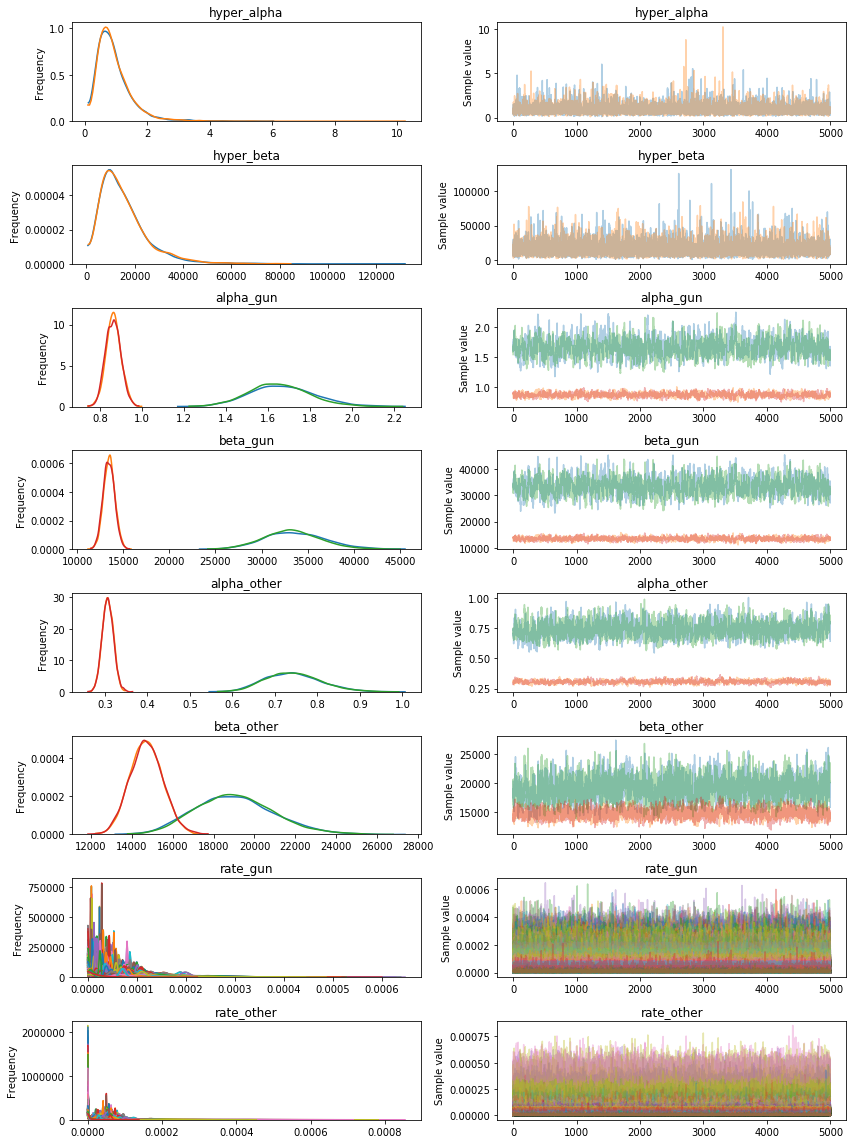

In [138]:
_ = pm.traceplot(trace_hyper_pty)

In [139]:
np.shape(trace_hyper_pty['beta_other'].mean(axis=0))

(2,)

In [140]:
res = pm.summary(trace_hyper_pty).reset_index()
res_gun = res[res['index'].str.startswith('rate_gun')]
res_other = res[res['index'].str.startswith('rate_other')]

In [141]:
suicides_gun['post_rate_hyp_pty'] = res_gun['mean'].values
suicides_gun['post_low_hyp_pty'] = res_gun['hpd_2.5'].values
suicides_gun['post_high_hyp_pty'] = res_gun['hpd_97.5'].values

suicides_other['post_rate_hyp_pty'] = res_other['mean'].values
suicides_other['post_low_hyp_pty'] = res_other['hpd_2.5'].values
suicides_other['post_high_hyp_pty'] = res_other['hpd_97.5'].values

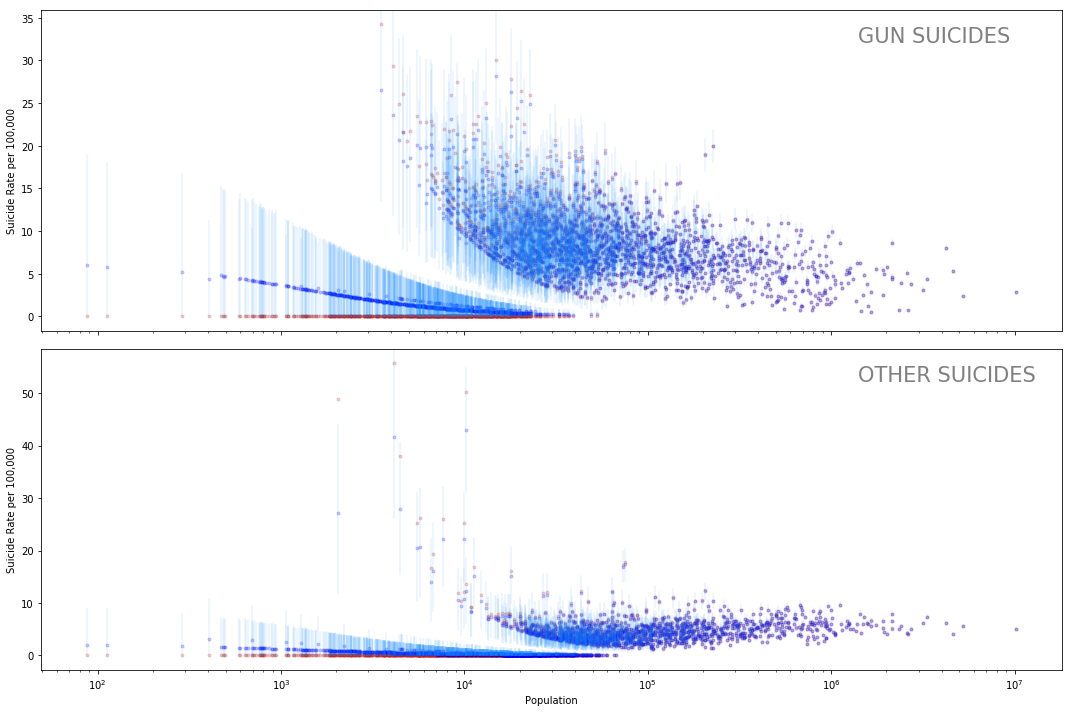

In [142]:
f, axes = plt.subplots(2, 1, figsize=(15,10), sharex=True)

for df, ax in zip([suicides_gun, suicides_other], axes):
    p1 = ax.plot(df['Population'], df['rate'] * 100000, '.', color='firebrick', alpha=0.2, label='suicides - gun')
    p2 = ax.plot(df['Population'], df['post_rate_hyp_pty'] * 100000, '.', color='blue', alpha=0.2, label='suicides - other') 
    ylow, yhigh = ax.get_ylim()
    for x,y1,y2 in df[['Population','post_low_hyp_pty', 'post_high_hyp_pty']].itertuples(index=False):
        p3 = ax.axvline(x, (y1 * 100000 - ylow) / (yhigh - ylow), (y2 * 100000 - ylow)/(yhigh - ylow) , color='dodgerblue', alpha = 0.1)

axes[0].annotate("GUN SUICIDES", xy=(0.8, 0.9), xycoords='axes fraction', fontsize=21, color='gray', ha='left' )
axes[1].annotate("OTHER SUICIDES", xy=(0.8, 0.9), xycoords='axes fraction', fontsize=21, color='gray', ha='left' )

axes[1].set_xlabel("Population")
axes[1].set_ylabel("Suicide Rate per 100,000")
axes[0].set_ylabel("Suicide Rate per 100,000")

plt.semilogx()
plt.tight_layout()

plt.savefig("./outputs/2018-06-15-hierarchical-party-shrinkage.png")

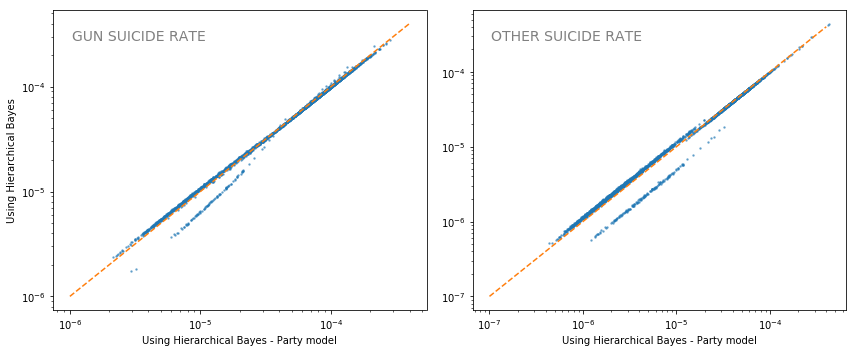

In [143]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.plot(suicides_gun['post_rate_hyp_pty'], suicides_gun['post_rate_hyp'], '.', ms=3, alpha=0.5)
ax1.plot([0.000001,0.0004], [0.000001, 0.0004], '--')

ax2.plot(suicides_other['post_rate_hyp_pty'], suicides_other['post_rate_hyp'], '.', ms=3, alpha=0.5)
ax2.plot([0.0000001,0.0004], [0.0000001, 0.0004], '--')
ax1.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
ax2.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
ax1.loglog()

ax1.set_ylabel("Using Hierarchical Bayes")
ax1.set_xlabel("Using Hierarchical Bayes - Party model")
ax2.set_xlabel("Using Hierarchical Bayes - Party model")
ax1.annotate("GUN SUICIDE RATE", xy=(0.05, 0.9), xycoords='axes fraction', fontsize=14, color='gray', ha='left' )
ax2.annotate("OTHER SUICIDE RATE", xy=(0.05, 0.9), xycoords='axes fraction', fontsize=14, color='gray', ha='left' )
ax2.loglog()

plt.tight_layout()
plt.savefig("./outputs/2018-06-15-hierarchical_pty_vs_hier.png")



In [95]:
suicides = suicides_gun.merge(suicides_other, on=['County','id2'], how='outer', 
                             suffixes=('_gun', '_other'))
suicides['Population'] = suicides[['Population_gun','Population_other']].values.mean(axis=1)
suicides2 = suicides.merge(election2016[['combined_fips','dem_or_gop']], left_on=['id2'], 
                   right_on='combined_fips', how='left')

#suicides2['Gun suicide rate'] = suicides2
suicides2.to_csv("./suicides_posterior.csv", index=False)

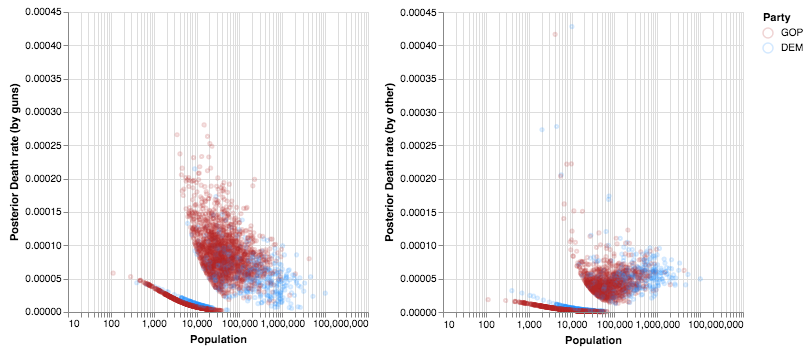

In [126]:
source = "https://raw.githubusercontent.com/sidravi1/sidravi1.github.io/master/assets/suicides_posterior.csv"

brush = alt.selection(type='interval', resolve='global', )

base = alt.Chart(source).mark_point(size=10, opacity=0.2).encode(
    x=alt.X('Population:Q',scale=alt.Scale(type='log')),
    color=alt.condition(brush, alt.Color('dem_or_gop:N',scale=alt.Scale(domain=['GOP','DEM'], range=['firebrick','dodgerblue']), title="Party"), alt.ColorValue('gray')),
    tooltip=['County:N', 'Deaths_gun:Q', 'Deaths_other:Q'] #alt.Tooltip(field='Deaths_gun', type='quantitative')
).add_selection(
    brush
).properties(
    width=300,
    height=300
)


left = base.encode(y=alt.Y('post_rate_hyp_pty_gun:Q', title='Posterior Death rate (by guns)'))
right = base.encode(y=alt.Y('post_rate_hyp_pty_other:Q', title='Posterior Death rate (by other)'))
alt.hconcat(left, right).resolve_scale(y='shared')
